In [2]:

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from transformers import pipeline
from PIL import Image
import pandas as pd

from jhu_handler import JHU_handler

DB = JHU_handler()

/home/gaetan/projects/projet-safeband/depth-measurement/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Head detection

In [3]:
photo_id = 1857 # 1857,1555, 1691, 2184, 4088

image 2256 with 325 heads

image 1/1 /mnt/c/Users/gaeta/OneDrive - CentraleSupelec/3A/Safeband/Projet - InfoNum/Datasets/BigDSimages/jhu_crowd_v2.0/jhu_crowd_v2.0/train/images/2256.jpg: 320x544 92 heads, 538.8ms
Speed: 11.2ms preprocess, 538.8ms inference, 14.0ms postprocess per image at shape (1, 3, 320, 544)
###################
image size: (1000, 562)
92 / 325 heads detected


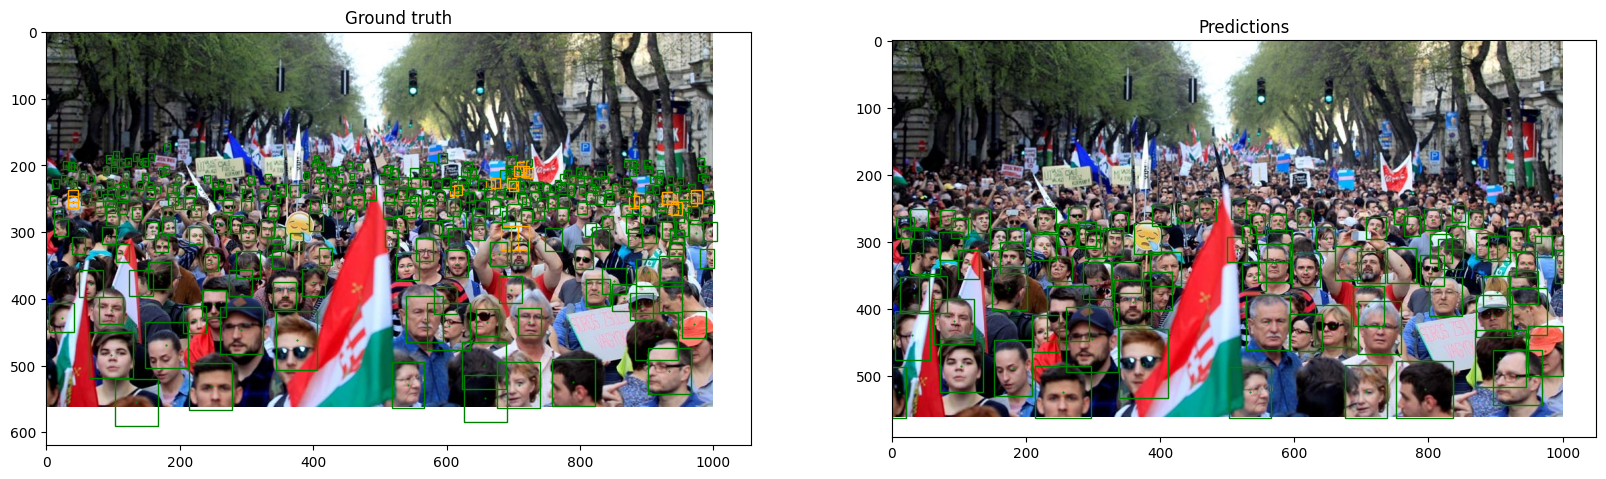

In [4]:
from ultralytics import YOLO
import cv2
import numpy as np

# Load the model
model = YOLO('models-checkpoints/bestyolo11l.pt')  # load the custom model from checkpoint

# Function to run inference on an image

# random image
image_path, heads, info = DB.get_image("2256")
# image_path, heads, info = DB.get_random_image()
print(f"image {info['filename']} with {info['total-count']} heads")

# print(heads)
results = model(image_path)
detected_heads = pd.DataFrame(columns=["x", "y", "w", "h"])
annotaded_image = results[0].plot()
# plt.imshow(annotaded_image)

for result in results:
    print("###################")
    boxes = result.boxes
    # print(boxes)
    for box in boxes:
        # print(box)
        x = box.xywh[0]
        new_row = {
            "x": float(x[0]),
            "y": float(x[1]), 
            "w": float(x[2]),
            "h": float(x[3])
        }
        # Ajouter la ligne au DataFrame
        detected_heads.loc[len(detected_heads)] = new_row
        
fig, axes = plt.subplots(1,2, figsize=(20,10)) 
image = Image.open(image_path)
print("image size:", image.size)
DB.show_img(image, ax=axes[0])
DB.show_img(image, ax=axes[1])
DB.show_headboxes(heads, ax=axes[0])
DB.show_headboxes(detected_heads, ax=axes[1])
axes[0].set_title("Ground truth")
axes[1].set_title("Predictions")

print(f"{len(detected_heads)} / {len(heads)} heads detected")
    
# print(result)

# Display the result

## depth estimation

In [5]:
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Metric-Outdoor-base-hf")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


image 2256 with 325 heads
image size: (1000, 562)
{'predicted_depth': tensor([[29.0099, 28.1801, 27.9095,  ..., 28.6576, 29.3056, 30.1254],
        [28.7232, 28.6981, 28.8033,  ..., 28.9506, 29.2160, 29.2786],
        [29.7319, 29.3078, 29.4882,  ..., 29.1737, 29.3255, 29.6448],
        ...,
        [ 5.3152,  5.4245,  5.4906,  ...,  4.7179,  4.6062,  4.7874],
        [ 5.3134,  5.4726,  5.3752,  ...,  4.6704,  4.7325,  4.8003],
        [ 5.2936,  5.5899,  5.6584,  ...,  4.9125,  4.8399,  5.1051]]), 'depth': <PIL.Image.Image image mode=L size=1000x562 at 0x7FE76D670EE0>}
depth shape torch.Size([562, 1000])


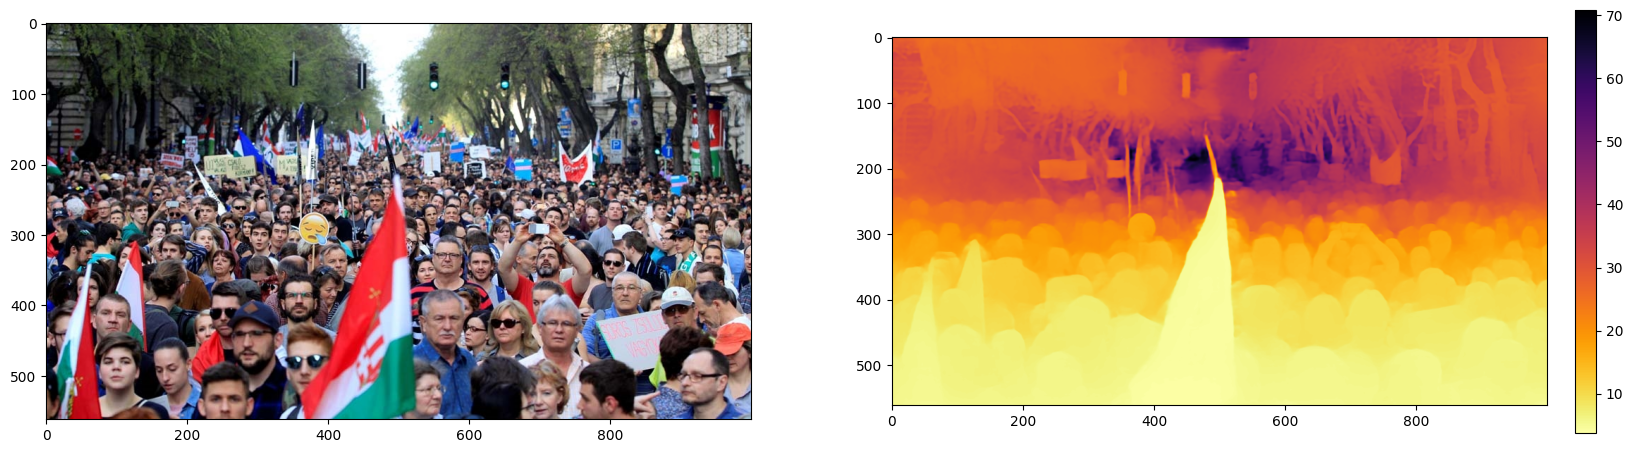

In [6]:

# 1555, 

img = Image.open(image_path)
print(f"image {info['filename']} with {info['total-count']} heads")
print("image size:", img.size)  
result = pipe(img)
print(result)
depth = result["predicted_depth"]
print("depth shape",depth.shape)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
DB.show_img(img,ax=axes[0])
# DB.show_headboxes(heads, ax=axes[0])
im2 = axes[1].imshow(depth, cmap='inferno_r' )
fig.colorbar(im2, ax=axes[1], fraction=0.03, pad=0.04)



Text(0, 0.5, 'depth')

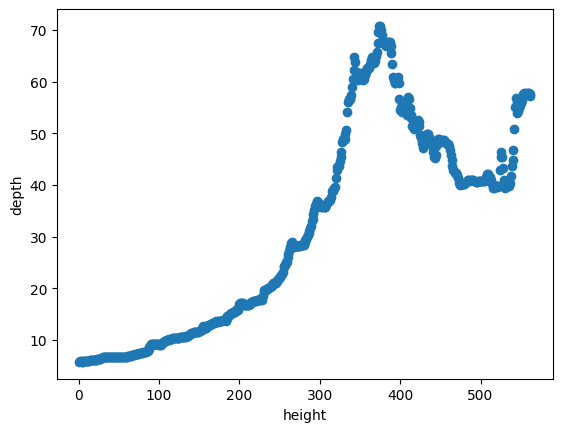

In [7]:
# angle estimation: 

# height according to the depth map

img.size, depth.size
heights = []
depths = []
for h in range(0, depth.shape[0]):
    # for w in range(0, depth.size[0], 10):
    depths.append(max([ depth[h, w] for w in range(0, depth.shape[1], 5)]))
    heights.append(depth.shape[0]-h)
        
plt.scatter(heights, depths)
plt.xlabel("height")
plt.ylabel("depth")
# for h in range(0)


## DISTANCE PREDICTION

### depth map linear corection

On tente de corriger la profondeur par régression linéaire en s'appuyant sur la taille des têtes détectées.
En effet, la mensurations des têtes est plutôt constant et a une faible variance, ce qui permet de l'utiliser comme variable explicative pour la profondeur.

or le produit $\text{taille tête} \times \text{profondeur}$ est proportionnel à la taille de la tête, on détermine donc une correction sous forme de régression pour redresser la distribution de ce produit par rapport à la profondeur.

Ceci nous permet théoriquement de corriger pas mal



Text(0, 0.5, 'depth * size')

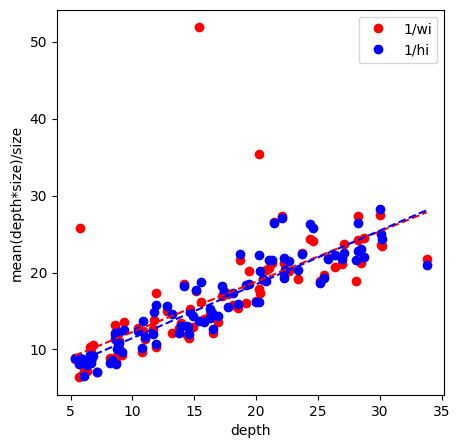

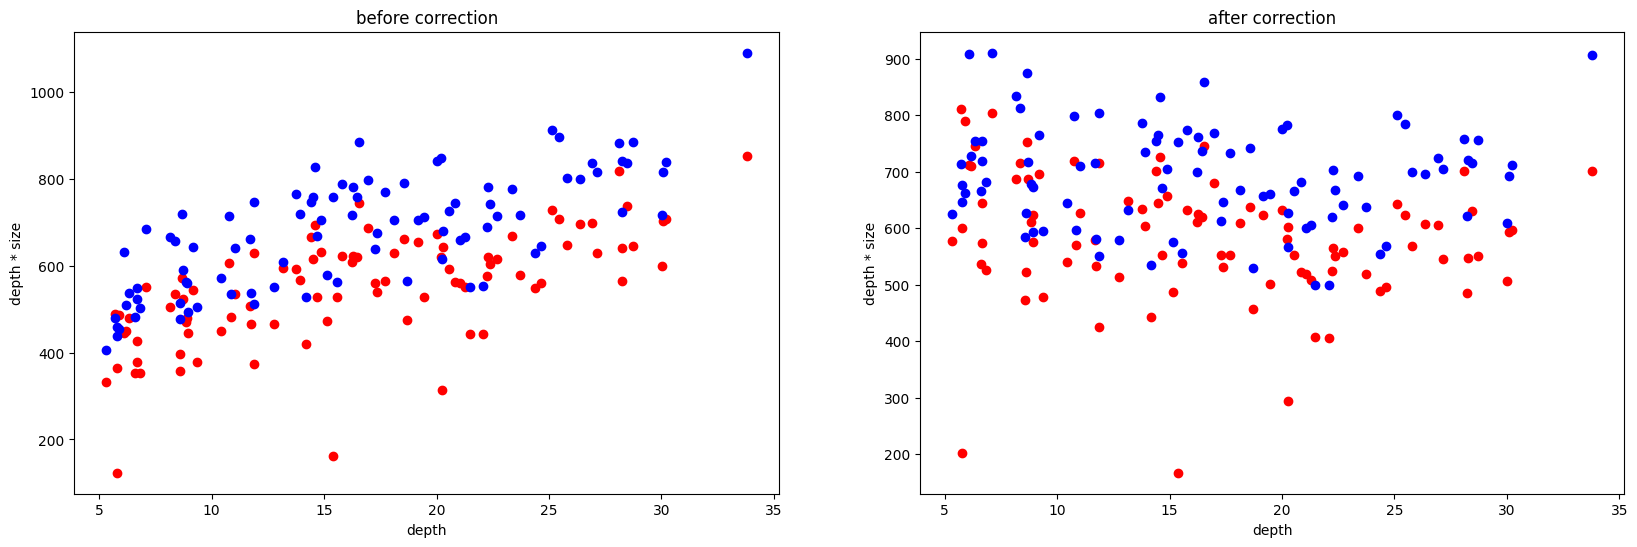

In [8]:

import scipy.optimize as opt

for i in range(len(detected_heads)):
    detected_heads.loc[i, 'depth'] = float(depth[int(detected_heads.loc[i, 'y']), int(detected_heads.loc[i, 'x'])])

obj_w = (detected_heads["w"]*detected_heads["depth"]).mean()
obj_h = (detected_heads["h"]*detected_heads["depth"]).mean()

scale = lambda x,a,b: a*x + b


popt_w, _ = opt.curve_fit(scale, detected_heads["depth"], detected_heads["w"].apply(lambda x : obj_w/x))
popt_h, _ = opt.curve_fit(scale, detected_heads["depth"], detected_heads["h"].apply(lambda x : obj_h/x))

figure = plt.figure(figsize=(5,5))
plt.plot(detected_heads["depth"], obj_w/detected_heads["w"], 'ro', label="1/wi")
plt.plot(detected_heads["depth"], obj_h/detected_heads["h"], 'bo', label="1/hi")
X = np.linspace(detected_heads["depth"].min(), detected_heads["depth"].max(), 100)
plt.plot(X, scale(X, *popt_w), 'r--')
plt.plot(X, scale(X, *popt_h), 'b--')
plt.xlabel("depth")
plt.ylabel("mean(depth*size)/size")
plt.legend()

fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(detected_heads["depth"], detected_heads["depth"]* detected_heads["w"], 'ro')
axes[0].plot(detected_heads["depth"], detected_heads["depth"]* detected_heads["h"], 'bo')
axes[0].set_xlabel("depth")
axes[0].set_ylabel("depth * size")
axes[0].set_title("before correction")

axes[1].plot(detected_heads["depth"], detected_heads["depth"].apply(lambda x : scale(x,*popt_w))*detected_heads["w"], 'ro')
axes[1].plot(detected_heads["depth"], detected_heads["depth"].apply(lambda x : scale(x,*popt_h))*detected_heads["h"], 'bo')
axes[1].set_xlabel("depth")
axes[1].set_ylabel("depth * size")
axes[1].set_title("after correction")

detected_heads["depth_scaled"] = detected_heads["depth"].apply(lambda x : scale(x,*popt_h))

# plt.plot(detected_heads["depth"], detected_heads["w"], 'bo')
plt.xlabel("depth")
plt.ylabel("depth * size")

to estimate the distance between the points, we need to know the focal length of the objectif, we will estimate it using the size of the heads wich is statistically often the same.

### Focal length estimation

see https://www.faa.gov/sites/faa.gov/files/data_research/research/med_humanfacs/oamtechreports/AM93-10.pdf

/tmp/ipykernel_2436/557792359.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  depth_corrected = np.array(depth)


<built-in method size of Tensor object at 0x7fe76d6db150>
(562, 1000)


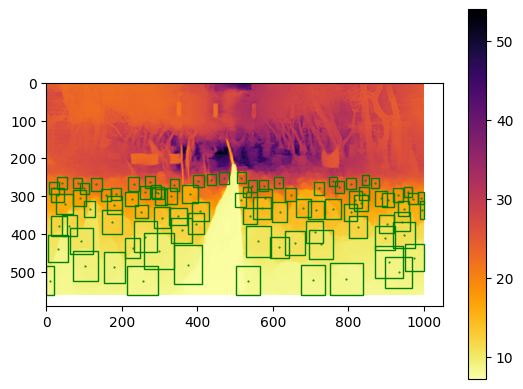

In [9]:
depth_corrected = np.array(depth)
depth_corrected = scale(depth_corrected,*popt_h)
# depth_corrected = Image.fromarray(depth_corrected)

plt.imshow(depth_corrected, cmap='inferno_r' )
plt.colorbar()
axe = plt.gca()
DB.show_headboxes(detected_heads, ax=axe)

print(depth.size)
print( depth_corrected.shape)

number_of_heads 92 / 325
Optimization terminated successfully.
         Current function value: -0.000829
         Iterations: 25
         Function evaluations: 50

Estimated focal (in pixels): 3160


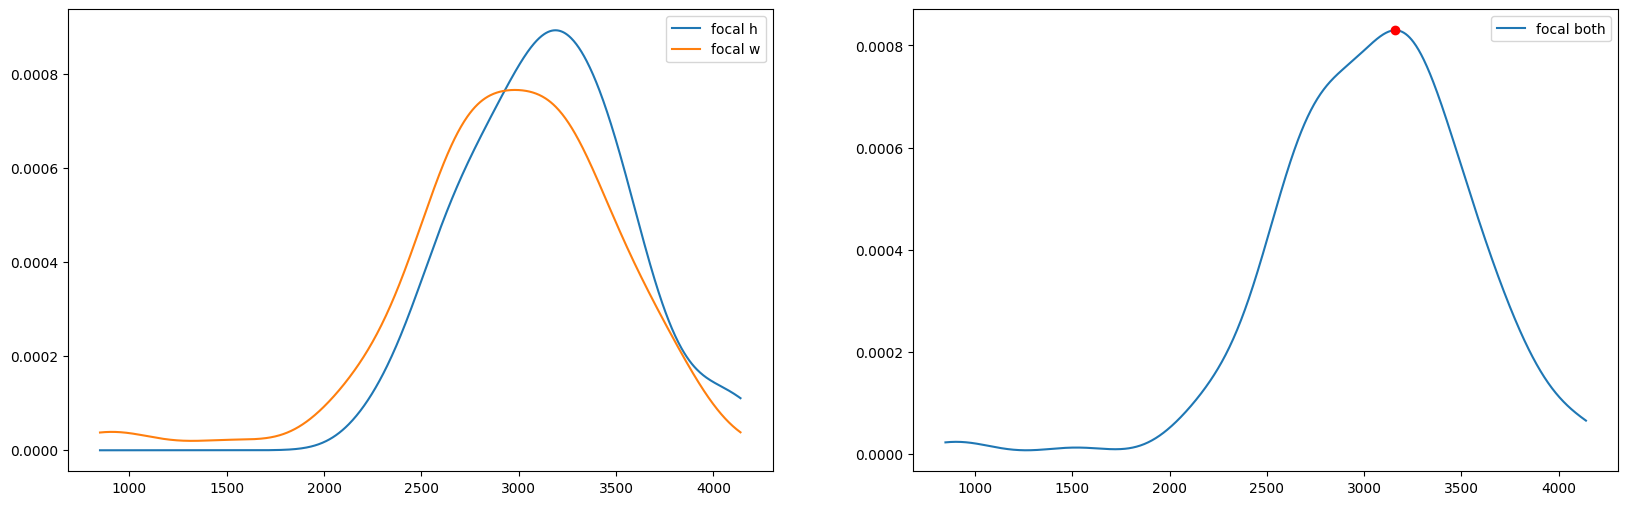

In [10]:
# good_images = 2165

import scipy.optimize as opt
import scipy.stats as stats

print("number_of_heads", len(detected_heads),"/", info['total-count'])

mean_height = 0.220 # m
mean_width = 0.190 # m


detected_heads["focal_w"] = detected_heads["depth_scaled"] * detected_heads["w"] / mean_width # largeur de tête moyenne
detected_heads["focal_h"] = detected_heads["h"] * detected_heads["depth_scaled"] / mean_height # hauteur de tête moyenne

focal_h_kde = stats.gaussian_kde(detected_heads["focal_h"])
focal_w_kde = stats.gaussian_kde(detected_heads["focal_w"])
# print(detected_heads[["focal_h","focal_w"]].to_numpy().flatten())
focal_both_kde = stats.gaussian_kde(detected_heads[["focal_h","focal_w"]].to_numpy().flatten())

xmin = detected_heads[["focal_h","focal_w"]].min(axis=None)
xmax = detected_heads[["focal_h","focal_w"]].max(axis=None)
x = np.linspace(xmin, xmax, 1000)

figure, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].plot(x, focal_h_kde(x), label="focal h")
axes[0].plot(x, focal_w_kde(x), label="focal w")
axes[0].legend()
axes[1].plot(x, focal_both_kde(x), label="focal both")
axes[1].legend()

# focal estimation

focal = int(opt.fmin(lambda x: -focal_both_kde(x), (xmin+xmax)/2)[0])
print("\nEstimated focal (in pixels):", focal)

axes[1].plot(focal, focal_both_kde(focal), 'ro')

# sns.kdeplot(detected_heads["focal_w"], ax=axes2[0])
# sns.kdeplot(detected_heads["focal_h"], ax=axes2[1])

# print("focal w, mean=",detected_heads["focal_w"].mean(),", std=",detected_heads["focal_w"].std())
# print("focal h, mean=",detected_heads["focal_h"].mean(),", std=",detected_heads["focal_h"].std())



### Distance estimation

we will use the focal length to estimate the distance between the heads on the y axis

In [11]:
import random as rd
rd1 = rd.randint(0, len(detected_heads))
rd2 = rd.randint(0, len(detected_heads))
print("head 1 (cyan) & head 2 (blue):", rd1,"&",rd2)
point_1 = detected_heads.loc[rd1, ["x", "y","depth_scaled"]]
point_2 = detected_heads.loc[rd2, ["x", "y","depth_scaled"]]

x1 = point_1["x"]
y1 = point_1["y"]
x2 = point_2["x"]
y2 = point_2["y"]
d1 = point_1["depth_scaled"]
d2 = point_2["depth_scaled"]


plt.imshow(image)
plt.plot([x1, x2], [y1, y2], '-',color='tab:red',  linewidth=2)
plt.plot([x1, x1], [y1, y2], '-',color='tab:green',linewidth=2)
plt.plot([x2, x2], [y1, y2], '-',color='tab:pink',linewidth=2)
plt.plot([x1, x2], [y2, y2], '-',color='tab:blue',linewidth=2)
plt.plot([x1, x2], [y1, y1], '-',color='cyan',linewidth=2)

plt.plot(x1, y1, 'o',color = "cyan")
plt.plot(x2, y2, 'o',color='blue')

print("depth 1:", d1,"m")
print("depth 2:", d2,"m")
print("d2-d1 =", d2-d1, "m")
print("blue :", round(np.abs(x2-x1)),"pxl")
print("green :", round(np.abs(y2-y1)),"pxl")
dy = np.sin np.sqrt( d1**2 + d2**2 - 2*d1*d2* ( 1 - ( np.abs(y2-y1)**2 / (2*(focal**2)) ) ) )
dx1 = (x2-x1) * d1 / focal
dx2 = (x2-x1) * d2 / focal

print("")
print("estimated distance in x axis at d1 (cyan) :", dx1,"m")
print("estimated distance in x axis at d2 (blue) :", dx2,"m")
print("")
print("estimated real x distance", (dx1+dx2)/2,"m")
print("estimated distance in y axis (green & pink) :", dy,"m")

SyntaxError: invalid syntax (1554715940.py, line 31)